# Animorphs Authenticity, Notebook 01
#### Ethan Henley

## Problem Statement:

When authorship is uncertain, specific word choices and text patterns can be used to determine whether or not a text was written by a certain author. We want to develop a model for reading in two large corpuses, one authentically written by an author and one ghostwritten, and predicting which corpus a text belongs to. 

One recent [paper](https://arxiv.org/abs/1911.05652) by Petr Plecháč analyzed the authorship of specific subsections of the play Henry VIII to determine where either of the authors suspected of involvement contributed. Its methodology is not directly applicable to non-poetic texts, as it greatly involves cadence and meter in its modeling process. We will to perform similar analysis on another, non-metered corpus to generalize author authenticity analysis.

For this analysis, we will use the Animorphs series, 54 children's science-fiction/fantasy books of which about half were ghostwritten, as our corpus. The model will be specific to this collection of books, but the strategies implemented should be relevant for other authorship analyses.

We will vectorize words in individual chapters of Animorphs books using Word2Vec against the corpus as a whole, and then take each chapter's average vector, reduce its dimensionality, and then use a Simple Vector Machine classifier to delineate author authenticity. The classifier will be scored on accuracy, as the two types of misattribution are similarly undesirable.

## Collection & EDA Process:

The corpus was gathered from [Richard's Animorphs Forum](https://animorphsforum.com/ebooks/), where the Animorphs series of books is hosted for free access with the blessing of the creator. We use the main series only. Authenicity was taken from [this Wikipedia section](https://en.wikipedia.org/wiki/Animorphs#Ghostwriters). Books were read chapter by chapter using `ebooklib` and `BeautifulSoup`. Chapters were processed, proper nouns and stopwords were removed, and then words were tokenized to develop a corpus. A first quick look showed what words were most common across the corpus.

In [1]:
import pandas as pd

import requests

import time

import re
from nltk.corpus import stopwords

import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup

from collections import Counter

import matplotlib.pyplot as plt

## Data Collection

Read out all the books' chapters into a two-layer dictionary. 

Books are downloaded as `.epub` files from [Richard's Animorphs Forum](https://animorphsforum.com/ebooks/).

In [2]:
# front of url for downloads
url_front = 'http://downloads.animorphsforum.com/books/epub/'

# need a standard user agent header to access file;
# default requests ua not accepted
headers = {'User-Agent':
           'Mozilla/5.0 (compatible, MSIE 11, Windows NT 6.3; '+\
               'Trident/7.0; rv:11.0) like Gecko'}

In [3]:
books_dict = {}

for book_no in range(1,55): # for each book in main series
    
    no_string = str(book_no).zfill(2) # format leading 0
    
    # read in book
    try: # is book already downloaded?
        book = epub.read_epub(f'../texts/animorphs_books/{no_string}.epub')
    except: # download book
        url = url_front + f'{no_string}.epub'
        res = requests.get(url, headers=headers) # request book
        assert res.status_code == 200
        # save book to file
        file = open(f'../texts/animorphs_books/{no_string}.epub','wb')
        file.write(res.content)
        file.close()
        time.sleep(2) # avoid hogging bandwidth
        book = epub.read_epub(f'../texts/animorphs_books/{no_string}.epub')        
    
    # get chapters and chapter-like things; index no.s may not correspond
    # to actual chapter no.s
    chapters = [c for c in book.get_items_of_type(ebooklib.ITEM_DOCUMENT)]

    chapter_dict = {}
    for chapter_no, chapter in enumerate(chapters): # for chapter in book
        
        # list of paragraphs as strings
        paragraphs = [b.text for b in 
                      BeautifulSoup(chapter.content, 'xml'
                                   ).find_all('p')][1:] # p0 always blank
        
        chapter_dict[chapter_no] = '\n'.join(paragraphs) # list as lines
        
    books_dict[book_no] = chapter_dict

Convert dictionary into df of chapters.

In [4]:
df_list = []

for k,v in books_dict.items():
    for vk,vv in v.items():
        df = pd.DataFrame({'book':k,
                           'chapter':vk,
                           'text':vv}, index=[0])
        df_list.append(df)

chaps_df = pd.concat(df_list).reset_index().drop(columns='index') # combine
chaps_df = chaps_df[chaps_df['text'] != ''] # clean 'empty' chapters

In [5]:
chaps_df

,book,chapter,text
1,1,1,"My name is Jake. That's my first name, obvious..."
2,1,2,"""A flying saucer?"" Marco said. He did laugh. T..."
3,1,3,<They have come to destroy you.>\nIt was stran...
4,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...
5,1,5,"The Hork-Bajir pointed his gun, or whatever it..."
...,...,...,...
1520,54,18,The world's smartest mouse wiggled his nose at...
1521,54,19,I had nine million four hundred and thirty-two...
1522,54,20,"We drove through the desert night, silent most..."
1523,54,21,The Rachel was fast.\nWe blew through normal s...


Add authenticity columns; 1 denotes a book written by Applegate, 0 denotes a book ghostwritten.

In [6]:
auths = [i for i in range(1,25)] + [26, 32, 53, 54]
chaps_df['authenticity'] = chaps_df['book'].map(lambda b: int(b in auths))

chaps_df.head()

,book,chapter,text,authenticity
1,1,1,"My name is Jake. That's my first name, obvious...",1
2,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1
3,1,3,<They have come to destroy you.>\nIt was stran...,1
4,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1
5,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1


## Cleaning

For Word2Vec analysis, will need to aggressively remove stopwords, including common proper nouns that may show up different amounts throughout the books. We will also need to remove all non-word elements, such as punctuation.

We remove proper nouns primarily to avoid 'cheating'; because each book has a perspective character, characters appear more often in some books than others, and this may inappropriately 'help' the model isolate individual books without using information related to author style.

Additionally, because this is a science fiction series, there are many alien species who come up in only some of the books; our list of proper nouns will not include the names of alien species that come up in most of the books.

In [7]:
# frequent character names and other proper nouns
# manually collected from the text and animorphs.fandom.com
names = ['jake','rachel','marco','james','craig','erica','tobias',
         'cassie','aximili','esgarrouth','isthill', 'ax',
         'aximiliesgarrouthisthill','david','melissa','chapman',
         'collette','kelly','timmy','julio','liam','tricia','jessie',
         'judy','ray', 'gafinilan','estrif','valad','gafinilanestrifvalad',
         'erek','king','tom','taylor','karen','arbat','elivat','estoni',
         'arbatelivatestoni','aldrea','iskillion','falan',
         'aldreaiskillionfalan','william','tennant','mertil','iscar',
         'elmand','mertiliscarelmand']
pnouns = ['taxon','helmacron','helmacrons','leera']

# some other stopwords to include
other_stops = ['said', 'like','one']

# all extra stopwords
extra_stops = names + pnouns + other_stops

In [8]:
# set up stopwords

stops = stopwords.words('english') + extra_stops

# clean stops to same format as other text

stops = re.sub(r'[^a-zA-Z ]','',' '.join(stops)).lower().split()

In [9]:
def clean_chapter(chapter, stops=stops, use_stops=True):
    """
    A function to clean and tokenize a chapter of text.
    """
    # regex non-letters, lowercase, tokenize
    chapter = chapter.replace('-',' ').replace('\n',' ')
    chapter = re.sub(r'[^a-zA-Z ]','',chapter).lower().split()
    if use_stops: # remove stopwords
        chapter = [w for w in chapter if w not in stops]
    return chapter

Check that the cleaning makes sense.

In [10]:
# test-visualize the start of a single chapter
chaps_df.loc[1,'text'][:198]

"My name is Jake. That's my first name, obviously. I can't tell you my last name. It would be too dangerous. The Controllers are everywhere. Everywhere. And if they knew my full name, they could find"

In [11]:
# test-visualize the same text, preprocessed
clean_chapter(chaps_df.loc[1,'text'][:198])

['name',
 'thats',
 'first',
 'name',
 'obviously',
 'cant',
 'tell',
 'last',
 'name',
 'would',
 'dangerous',
 'controllers',
 'everywhere',
 'everywhere',
 'knew',
 'full',
 'name',
 'could',
 'find']

Cleaned text makes sense. Create cleaned chapter text column.

In [12]:
chaps_df['clean'] = chaps_df['text'].map(clean_chapter)
chaps_df.head()

,book,chapter,text,authenticity,clean
1,1,1,"My name is Jake. That's my first name, obvious...",1,"[name, thats, first, name, obviously, cant, te..."
2,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1,"[flying, saucer, laugh, looked, could, feel, h..."
3,1,3,<They have come to destroy you.>\nIt was stran...,1,"[come, destroy, strange, way, knew, telling, t..."
4,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1,"[yeerks, twin, red, lights, slowed, turned, ci..."
5,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1,"[hork, bajir, pointed, gun, whatever, around, ..."


Just in case we don't want to use stopwords, add another column that hasn't removed them.

In [13]:
chaps_df['clean_no_stops'] = \
    chaps_df['text'].map(lambda t: clean_chapter(t,use_stops=False))
chaps_df.head()

,book,chapter,text,authenticity,clean,clean_no_stops
1,1,1,"My name is Jake. That's my first name, obvious...",1,"[name, thats, first, name, obviously, cant, te...","[my, name, is, jake, thats, my, first, name, o..."
2,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1,"[flying, saucer, laugh, looked, could, feel, h...","[a, flying, saucer, marco, said, he, did, laug..."
3,1,3,<They have come to destroy you.>\nIt was stran...,1,"[come, destroy, strange, way, knew, telling, t...","[they, have, come, to, destroy, you, it, was, ..."
4,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1,"[yeerks, twin, red, lights, slowed, turned, ci...","[yeerks, the, twin, red, lights, slowed, they,..."
5,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1,"[hork, bajir, pointed, gun, whatever, around, ...","[the, hork, bajir, pointed, his, gun, or, what..."


Save DataFrame.

In [14]:
chaps_df.to_csv('../data/animorphs_chaps.csv', index=False)

## Exploratory Data Analysis

Establish entire corpus.

In [15]:
corpus = []
for chapter in chaps_df['clean']:
    corpus += chapter

### Frequent Words

Look at frequently occurring words across the corpus.

In [16]:
def freq_words(word_list, n=10):
    """
    A function to return the n most frequent entries in a list
    in a dict with their frequencies.
    """
    return {c[0]:c[1] for c in Counter(word_list).most_common(n)}

def chapter_freq_words(chapter, n=10, need_clean=False):
    """
    A function to optionally clean a chapter and then return the n
    most frequent entries in the chapter in a dict with their frequencies.
    """
    if need_clean:
        chapter = clean_chapter(chapter)
    return freq_words(chapter, n)

def book_freq_words(book_no, col='clean', chaps_df=chaps_df, n=10):
    """
    A function to concat cleaned chapters of a book into a list and
    then return the n most frequent entries in the book in a dict
    with their frequencies.
    """
    book = []
    for chapter in chaps_df.loc[chaps_df['book']==book_no, col]:
        book += chapter
    return freq_words(book, n)

In [17]:
top_freqs = freq_words(corpus, n=20)

In [18]:
def sort_plot_dict_barh(this_dict, title='', top_n=None):
    """
    A function to sort a dictionary of int values and then plot a barh.
    """
    if top_n is None:
        top_n = len(this_dict)
    
    # sort dict
    this_dict = {k:v for k,v in
                 sorted(this_dict.items(),
                        key=(lambda kv:kv[1]))[-top_n:]}
    
    plt.figure(figsize=(8,6))
    plt.title(title)
    # super elegant dict bar adapted from ImportanceOfBeingErnest at
    # stackoverflow.com/questions/16010869
    plt.barh(*zip(*this_dict.items()), color='#888888')

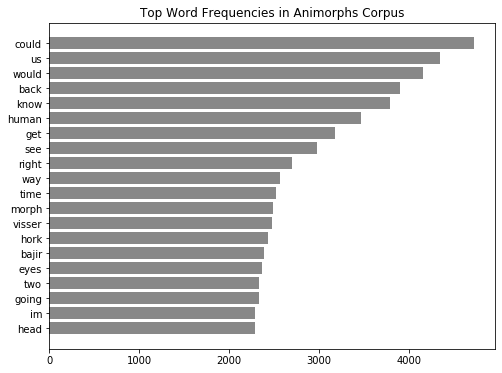

In [19]:
sort_plot_dict_barh(top_freqs,
                    'Top Word Frequencies in Animorphs Corpus')
plt.savefig('../figures/a_corpus_top_words.png')

What is the most common word in each chapter?

In [20]:
most_common = {i:chapter_freq_words(chaps_df.loc[i, 'clean'], n=1) 
               for i in chaps_df.index}
most_common_w = [list(v.keys())[0] for v in most_common.values()]
most_common_counts = {w:most_common_w.count(w) for w in set(most_common_w)}

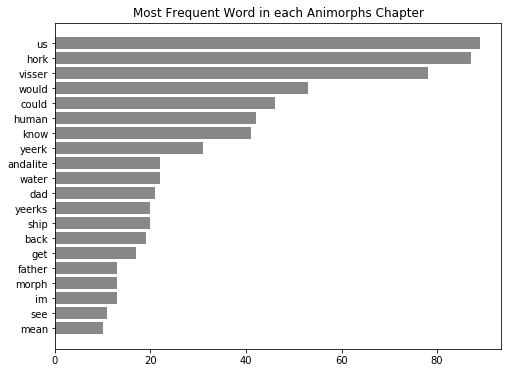

In [21]:
sort_plot_dict_barh(most_common_counts,
                    'Most Frequent Word in each Animorphs Chapter',
                    top_n = 20)
plt.savefig('../figures/a_chap_top_words.png')

What is the most common word in each book?

In [22]:
most_common = {book_no:book_freq_words(book_no, n=1) 
               for book_no in range(1,55)}
most_common_w = [list(v.keys())[0] for v in most_common.values()]
most_common_counts = {w:most_common_w.count(w) for w in set(most_common_w)}

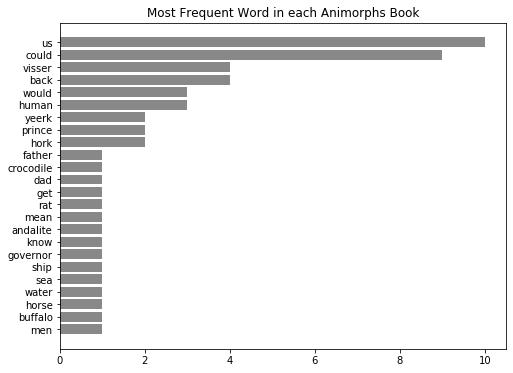

In [23]:
sort_plot_dict_barh(most_common_counts,
                    'Most Frequent Word in each Animorphs Book')
plt.savefig('../figures/a_books_top_words.png')

Is there a visible relationship between authenticity and most common word in book?

In [24]:
most_common_df = pd.DataFrame({'book':range(1,55),
                               'authenticity':list(chaps_df.groupby('book')[
                                   'authenticity'].mean()),
                               'most_common_w':most_common_w})
most_common_df.head()

,book,authenticity,most_common_w
0,1,1,could
1,2,1,visser
2,3,1,could
3,4,1,know
4,5,1,us


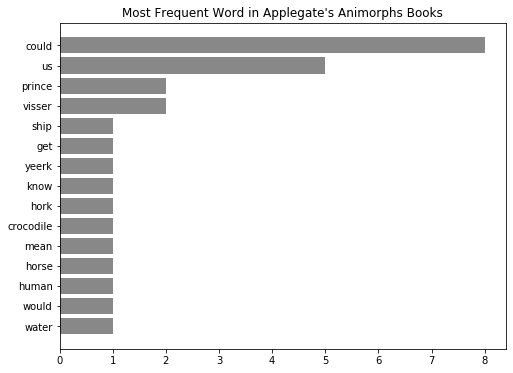

In [25]:
sort_plot_dict_barh(most_common_df.loc[most_common_df['authenticity']==1,
                                       'most_common_w'
                                      ].value_counts().to_dict(),
                   'Most Frequent Word in Applegate\'s Animorphs Books')
plt.savefig('../figures/a_authbooks_top_words.png')

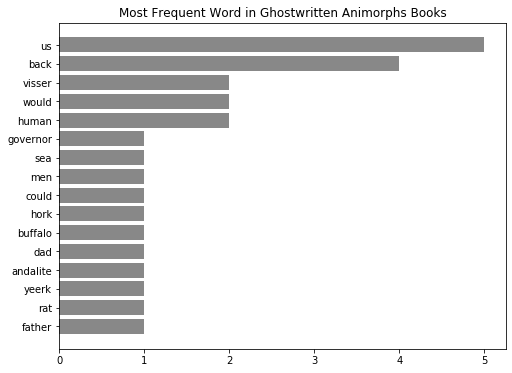

In [26]:
sort_plot_dict_barh(most_common_df.loc[most_common_df['authenticity']==0,
                                       'most_common_w'
                                      ].value_counts().to_dict(),
                   'Most Frequent Word in Ghostwritten Animorphs Books')
plt.savefig('../figures/a_inauthbooks_top_words.png')

At this point we must consider words that are most common in one book only—some models may use these as highly important features, even if they are less related to author style and more related to individual books' subjects. Based on experience, we know that many books frequently name one or two animals that only come up rarely in the other books.

We may ultimately want to include most of the stopwords we tried removing, depending on our modeling technique; they may be more indicative of style. 